##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Distributed Inference with JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Distributed_Inference_with_JAX"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Distributed_Inference_with_JAX.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Distributed_Inference_with_JAX.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Distributed_Inference_with_JAX.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

TensorFlow Probability (TFP) on JAX now has tools for distributed numerical computing. To scale to large numbers of accelerators, the tools are built around writing code using the "single-program multiple-data" paradigm, or SPMD for short. 

In this notebook, we'll go over how to "think in SPMD" and introduce the new TFP abstractions for scaling to configurations such as TPU pods, or clusters of GPUs. If you're running this code yourself, make sure to select a TPU runtime.

We'll first install the latest versions TFP, JAX and TF.

In [0]:
#@title Installs
!pip install jaxlib --upgrade -q 2>&1 1> /dev/null
!pip install tfp-nightly[jax] --upgrade -q 2>&1 1> /dev/null
!pip install tf-nightly-cpu -q -I 2>&1 1> /dev/null
!pip install jax -I -q --upgrade 2>&1 1>/dev/null

ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: tf-nightly-cpu 2.6.0.dev20210401 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR:

We'll import some general libraries, along with some JAX utilities.

In [0]:
#@title Setup and Imports
import functools
import collections
import contextlib

import jax
import jax.numpy as jnp
from jax import lax
from jax import random
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow_datasets as tfds

from tensorflow_probability.substrates import jax as tfp

sns.set(style='white')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


We'll also set up some handy TFP aliases. The new abstractions are currently provided in `tfp.experimental.distribute` and `tfp.experimental.mcmc`.

In [0]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfm = tfp.mcmc
tfed = tfp.experimental.distribute
tfde = tfp.experimental.distributions
tfem = tfp.experimental.mcmc

Root = tfed.JointDistributionCoroutine.Root

To connect the notebook to a TPU, we use the following helper from JAX. To confirm that we're connected, we print out the number of devices, which should be eight.

In [0]:
from jax.tools import colab_tpu
colab_tpu.setup_tpu()
print(f'Found {jax.device_count()} devices')

Found 8 devices


# A quick introduction to `jax.pmap`

After connecting to a TPU, we have access to *eight* devices. However, when we run JAX code eagerly, JAX defaults to running computations on just one.

The simplest way of executing a computation across many devices is to map a function, having each device execute one index of the map. JAX provides the `jax.pmap` ("parallel map") transformation which turns a function into one that maps the function across several devices.

In the following example, we create an array of size 8 (to match the number of available devices) and map a function that adds 5 across it.

In [0]:
xs = jnp.arange(8.)
out = jax.pmap(lambda x: x + 5.)(xs)
print(type(out), out)

<class 'jax.interpreters.pxla.ShardedDeviceArray'> [ 5.  6.  7.  8.  9. 10. 11. 12.]


Note that we receive a `ShardedDeviceArray` type back, indicating that the output array is physically split across devices.

`jax.pmap` acts semantically like a map, but has a few important options that modify its behavior. By default, `pmap` assumes all inputs to the function are being mapped over, but we can modify this behavior with the `in_axes` argument.

In [0]:
xs = jnp.arange(8.)
y = 5.
# Map over the 0-axis of `xs` and don't map over `y`
out = jax.pmap(lambda x, y: x + y, in_axes=(0, None))(xs, y)
print(out)

[ 5.  6.  7.  8.  9. 10. 11. 12.]


Analogously, the `out_axes` argument to `pmap` determines whether or not to return the values on every device. Setting `out_axes` to `None` automatically returns the value on the 1st device and should only be used if we are confident the values are the same on every device.

In [0]:
xs = jnp.ones(8) # Value is the same on each device
out = jax.pmap(lambda x: x + 1, out_axes=None)(xs)
print(out)

2.0


What happens when what we'd like to do isn't easily expressible as a mapped pure function? For example, what if we'd like to do a sum across the axis we're mapping over? JAX offers "collectives", functions that communicate across devices, to enable writing more interesting and complex distributed programs. To understand how exactly they work, we'll introduce SPMD.

# What is SPMD?

Single-program multiple-data (SPMD) is a concurrent programming model in which a single program (i.e. the same code) is executed simultaneously across devices, but the inputs to each of the running programs can differ.

If our program is a simple function of its inputs (i.e. something like `x + 5`), running a program in SPMD is just mapping it over different data, like we did with `jax.pmap` earlier. However, we can do more than just "map" a function.  JAX offers "collectives", which are functions that communicate across devices.

For example, maybe we'd like to take the sum of a quantity across all our devices. Before we do that, we need to assign a name to the axis we're mapping over in the `pmap`. We then use the `lax.psum` ("parallel sum") function to perform a sum across devices, ensuring we identify the named axis we're summing over.

In [0]:
def f(x):
  out = lax.psum(x, axis_name='i')
  return out
xs = jnp.arange(8.) # Length of array matches number of devices
jax.pmap(f, axis_name='i')(xs)

ShardedDeviceArray([28., 28., 28., 28., 28., 28., 28., 28.], dtype=float32)

The `psum` collective aggregates the value of `x` on each device and synchronizes its value across the map i.e. `out` is `28.` on each device.
We're no longer performing a simple "map", but we're executing an SPMD program where each device's computation can now interact with the same computation on other devices, albeit in a limited way using collectives. In this scenario, we can use `out_axes = None`, because `psum` will synchronize the value.

In [0]:
def f(x):
  out = lax.psum(x, axis_name='i')
  return out
jax.pmap(f, axis_name='i', out_axes=None)(jnp.arange(8.))

ShardedDeviceArray(28., dtype=float32)

SPMD enables us to write one program that is run on every device in any TPU configuration simultaneously. The same code that is used to do machine learning on 8 TPU cores can be used on a TPU pod that may have hundreds to thousands of cores! For a more detailed tutorial about `jax.pmap` and SPMD, you can refer to the the [JAX 101 tutorial](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html).

# MCMC at scale

In this notebook, we focus on using Markov Chain Monte Carlo (MCMC) methods for Bayesian inference. There are may ways we utilize many devices for MCMC, but in this notebook, we'll focus on two:
1. Running independent Markov chains on different devices. This case is fairly simple and is possible to do with vanilla TFP.
2. Sharding a dataset across devices. This case is a bit more complex and requires recently added TFP machinery.

## Independent Chains

Say we'd like to do Bayesian inference on a problem using MCMC and would like to run several chains in parallel across several devices (say 2 on each device). This turns out to be a program we can just "map" across devices, i.e. one that needs no collectives. To make sure each program executes a different Markov chain (as opposed to running the same one), we pass in a different value for the random seed to each device.

Let's try it on a toy problem of sampling from a 2-D Gaussian distribution. We can use TFP's existing MCMC functionality out of the box.
In general, we try to put most of the logic inside of our mapped function to more explicitly distinguish between what's running on all the devices versus just the first.

In [0]:
def run(seed):
  target_log_prob = tfd.Sample(tfd.Normal(0., 1.), 2).log_prob

  initial_state = jnp.zeros([2, 2]) # 2 chains
  kernel = tfm.HamiltonianMonteCarlo(target_log_prob, 1e-1, 10)
  def trace_fn(state, pkr):
    return target_log_prob(state)

  states, log_prob = tfm.sample_chain(
    num_results=1000,
    num_burnin_steps=1000,
    kernel=kernel,
    current_state=initial_state,
    trace_fn=trace_fn,
    seed=seed
  )
  return states, log_prob

By itself, the `run` function takes in a stateless random seed (to see how stateless randomness work, you can read the [TFP on JAX](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX) notebook or see the [JAX 101 tutorial](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html)). Mapping `run` over different seeds will result in running several independent Markov chains.

In [0]:
states, log_probs = jax.pmap(run)(random.split(random.PRNGKey(0), 8))
print(states.shape, log_probs.shape)
# states is (8 devices, 1000 samples, 2 chains, 2 dimensions)
# log_prob is (8 devices, 1000 samples, 2 chains)

(8, 1000, 2, 2) (8, 1000, 2)


Note how we now have an extra axis corresponding to each device. We can rearrange the dimensions and flatten them to get an axis for the 16 chains.

In [0]:
states = states.transpose([0, 2, 1, 3]).reshape([-1, 1000, 2])
log_probs = log_probs.transpose([0, 2, 1]).reshape([-1, 1000])

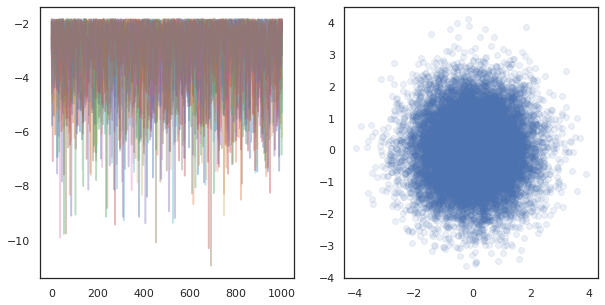

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(log_probs.T, alpha=0.4)
ax[1].scatter(*states.reshape([-1, 2]).T, alpha=0.1)
plt.show()

When running independent chains on many devices, it's as easy as `pmap`-ing over a function that uses `tfp.mcmc`, ensuring we pass different values for the random seed to each device.

## Sharding data

When we do MCMC, the target distribution is often a posterior distribution obtained by conditioning on a dataset, and computing an unnormalized log-density involves summing likelihoods for each observed data. 

With very large datasets, it can be prohibitively expensive to even run one chain on a single device. However, when we have access to multiple devices, we can split up the dataset across the devices to better leverage the compute we have available.

If we'd like to do MCMC with a sharded dataset, we need to ensure the unnormalized log-density we compute on each device represents the *total*, i.e. the density over all data, otherwise each device will be doing MCMC with their own incorrect target distribution. To this end, TFP now has new tools (i.e. `tfp.experimental.distribute` and `tfp.experimental.mcmc`) that enable computing "sharded" log probabilities and doing MCMC with them.

### Sharded distributions

The core abstraction TFP now provides for computing sharded log probabiliities is the `Sharded` meta-distribution, which takes a distribution as input and returns a new distribution that has specific properties when executed in an SPMD context. `Sharded` lives in `tfp.experimental.distribute`.

Intuitively, a `Sharded` distribution corresponds to a set of random variables that have been "split" across devices. On each device, they will produce different samples, and can individually have different log-densities. Alternatively, a `Sharded` distribution corresponds to a "plate" in graphical model parlance, where the plate size is the number of devices.


#### Sampling a `Sharded` distribution

If we sample from a `Normal` distribution in a program being `pmap`-ed using the same seed on each device, we will get the same sample on each device. We can think of the following function as sampling a single random variable that is synchronized across devices.

In [0]:
# `pmap` expects at least one value to be mapped over, so we provide a dummy one
def f(seed, _):
  return tfd.Normal(0., 1.).sample(seed=seed)
jax.pmap(f, in_axes=(None, 0))(random.PRNGKey(0), jnp.arange(8.))

ShardedDeviceArray([-0.20584236, -0.20584236, -0.20584236, -0.20584236,
                    -0.20584236, -0.20584236, -0.20584236, -0.20584236],                   dtype=float32)

If we wrap `tfd.Normal(0., 1.)` with a `tfed.Sharded`, we logically now have eight different random variables (one on each device) and will therefore produce a different sample for each one, despite passing in the same seed.

In [0]:
def f(seed, _):
  return tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i').sample(seed=seed)
jax.pmap(f, in_axes=(None, 0), axis_name='i')(random.PRNGKey(0), jnp.arange(8.))

ShardedDeviceArray([ 1.2152631 ,  0.7818249 ,  0.32549605,  0.6828047 ,
                     1.3973192 , -0.57830244,  0.37862757,  2.7706041 ],                   dtype=float32)

An equivalent representation of this distribution on a single device is just a 8 independent normal samples. Even though the value of the sample will be different (`tfed.Sharded` does pseudo-random number generation slightly differently), they both represent the same distribution.

In [0]:
dist = tfd.Sample(tfd.Normal(0., 1.), jax.device_count())
dist.sample(seed=random.PRNGKey(0))

DeviceArray([ 0.08086783, -0.38624594, -0.3756545 ,  1.668957  ,
             -1.2758069 ,  2.1192007 , -0.85821325,  1.1305912 ],            dtype=float32)

#### Taking the log-density of a `Sharded` distribution

Let's see what happens when we compute the log-density of a sample from a regular distribution in an SPMD context.

In [0]:
def f(seed, _):
  dist = tfd.Normal(0., 1.)
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
jax.pmap(f, in_axes=(None, 0))(random.PRNGKey(0), jnp.arange(8.))

(ShardedDeviceArray([-0.20584236, -0.20584236, -0.20584236, -0.20584236,
                     -0.20584236, -0.20584236, -0.20584236, -0.20584236],                   dtype=float32),
 ShardedDeviceArray([-0.94012403, -0.94012403, -0.94012403, -0.94012403,
                     -0.94012403, -0.94012403, -0.94012403, -0.94012403],                   dtype=float32))

Each sample is the same on each device, so we compute the same density on each device too. Intuitively, here we only have a distribution over a single normally distributed variable.

With a `Sharded` distribution, we have a distribution over 8 random variables, so when we compute the `log_prob` of a sample, we sum, across devices, over each of the individual log densities. (You might notice that this total log_prob value is larger than the singleton log_prob computed above.)

In [0]:
def f(seed, _):
  dist = tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i')
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
sample, log_prob = jax.pmap(f, in_axes=(None, 0), axis_name='i')(
    random.PRNGKey(0), jnp.arange(8.))
print('Sample:', sample)
print('Log Prob:', log_prob)

Sample: [ 1.2152631   0.7818249   0.32549605  0.6828047   1.3973192  -0.57830244
  0.37862757  2.7706041 ]
Log Prob: [-13.7349205 -13.7349205 -13.7349205 -13.7349205 -13.7349205 -13.7349205
 -13.7349205 -13.7349205]


The equivalent, "unsharded" distribution produces the same log density.

In [0]:
dist = tfd.Sample(tfd.Normal(0., 1.), jax.device_count())
dist.log_prob(sample)

DeviceArray(-13.7349205, dtype=float32)

A `Sharded` distribution produces different values from `sample` on each device, but get the same value for `log_prob` on each device. What's happening here? A `Sharded` distribution does a `psum` internally to ensure the `log_prob` values are in sync across devices. Why would we want this behavior? If we're running the *same* MCMC chain on each device, we'd like the `target_log_prob` to be the same across each device, even if some random variables in the computation are sharded across devices.

Additionally, a `Sharded` distribution ensures that gradients across devices are the correct, to ensure that algorithms like HMC, which take gradients of the log-density function as part of the transition function, produce proper samples.

### Sharded `JointDistribution`s

We can create models with multiple `Sharded` random variables by using `JointDistribution`s (JDs). Unfortunately, `Sharded` distributions cannot be safely used with vanilla `tfd.JointDistribution`s, but `tfp.experimental.distribute` exports "patched" JDs that will behave like `Sharded` distributions.

In [0]:
def f(seed, _):
  dist = tfed.JointDistributionSequential([
    tfd.Normal(0., 1.),
    tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i'),
  ])
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
jax.pmap(f, in_axes=(None, 0), axis_name='i')(random.PRNGKey(0), jnp.arange(8.))

([ShardedDeviceArray([1.6121525, 1.6121525, 1.6121525, 1.6121525, 1.6121525,
                      1.6121525, 1.6121525, 1.6121525], dtype=float32),
  ShardedDeviceArray([ 0.8690128 , -0.83167845,  1.2209264 ,  0.88412696,
                       0.76478404, -0.66208494, -0.0129658 ,  0.7391483 ],                   dtype=float32)],
 ShardedDeviceArray([-12.214451, -12.214451, -12.214451, -12.214451,
                     -12.214451, -12.214451, -12.214451, -12.214451],                   dtype=float32))

These sharded JDs can have both `Sharded` and vanilla TFP distributions as components. For the unsharded distributions, we obtain the same sample on each device, and for the sharded distributions, we get different samples. The `log_prob` on each device is synchronized as well.

### MCMC with `Sharded` distributions

How do we think about `Sharded` distributions in the context of MCMC? If we have a generative model that can be expressed as a `JointDistribution`, we can pick some axis of that model to "shard" across. Typically, one random variable in the model will correspond to observed data, and if we have a large dataset that we'd like to shard across devices, we want the variables that are associated to data points to be sharded as well. We also may have "local" random variables that are one-to-one with the observations we are sharding, so we will have to additionally shard those random variables.

We'll go over examples of the usage of `Sharded` distributions with TFP MCMC in this section. We'll start with a simpler Bayesian logistic regression example, and conclude with a matrix factorization example, with the goal of demonstrating some use-cases for the `distribute` library.


##### Example: Bayesian logistic regression for MNIST

We'd like to do Bayesian logistic regression on a large dataset; the model has a prior $p(\theta)$ over the regression weights, and a likelihood $p(y_i | \theta, x_i)$ that is summed over all data $\{x_i, y_i\}_{i = 1}^N$ to obtain the total joint log density. If we shard our data, we'd shard the observed random variables $x_i$ and $y_i$ in our model. 

We use the following Bayesian logistic regression model for MNIST classification:
$$
\begin{align*}
w &\sim \mathcal{N}(0, 1) \\
b &\sim \mathcal{N}(0, 1) \\
y_i | w, b, x_i &\sim \textrm{Categorical}(w^T x_i + b)
\end{align*}
$$

Let's load MNIST using TensorFlow Datasets.

In [0]:
mnist = tfds.as_numpy(tfds.load('mnist', batch_size=-1))
raw_train_images, train_labels = mnist['train']['image'], mnist['train']['label']
train_images = raw_train_images.reshape([raw_train_images.shape[0], -1]) / 255.

raw_test_images, test_labels = mnist['test']['image'], mnist['test']['label']
test_images = raw_test_images.reshape([raw_test_images.shape[0], -1]) / 255.

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


We have 60000 training images but let's take advantage of our 8 available cores and split it 8 ways. We'll use this handy `shard` utility function.

In [0]:
def shard_value(x):
  x = x.reshape((jax.device_count(), -1, *x.shape[1:]))
  return jax.pmap(lambda x: x)(x) # pmap will physically place values on devices

shard = functools.partial(jax.tree_map, shard_value)

In [0]:
sharded_train_images, sharded_train_labels = shard((train_images, train_labels))
print(sharded_train_images.shape, sharded_train_labels.shape)

(8, 7500, 784) (8, 7500)


Before we continue, let's quickly discuss precision on TPUs and its impact on HMC. TPUs execute matrix multiplications using low `bfloat16` precision for speed. `bfloat16` matrix multiplications are often sufficient for many deep learning applications, but when used with HMC, we have empirically found the lower precision can lead to diverging trajectories, causing rejections. We can use higher precision matrix multiplications, at the cost of some additional compute.

To increase our matmul precision, we can use the `jax.default_matmul_precision` decorator with `"tensorfloat32"` precision (for even higher precision we could use `"float32"` precision).

Let's now define our `run` function, which will take in a random seed (which will be the same on each device) and a shard of MNIST. The function will implement the aforementioned model and we will then use TFP's vanilla MCMC functionality to run a single chain. We'll make sure to decorate `run` with the `jax.default_matmul_precision` decorator to make sure the matrix multiplication is run with higher precision, though in the particular example below, we could just as well use `jnp.dot(images, w, precision=lax.Precision.HIGH)`.

In [0]:
# We can use `out_axes=None` in the `pmap` because the results will be the same
# on every device. 
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, 0), out_axes=None)
@jax.default_matmul_precision('tensorfloat32')
def run(seed, data):
  images, labels = data # a sharded dataset
  num_examples, dim = images.shape
  num_classes = 10

  def model_fn():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.), [dim, num_classes]))
    b = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_classes]))
    logits = jnp.dot(images, w) + b
    yield tfed.Sharded(tfd.Independent(tfd.Categorical(logits=logits), 1),
                       shard_axis_name='data')
  model = tfed.JointDistributionCoroutine(model_fn)

  init_seed, sample_seed = random.split(seed)

  initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`

  def target_log_prob(*state):
    return model.log_prob((*state, labels))

  def accuracy(w, b):
    logits = images.dot(w) + b
    preds = logits.argmax(axis=-1)
    # We take the average accuracy across devices by using `lax.pmean`
    return lax.pmean((preds == labels).mean(), 'data')

  kernel = tfm.HamiltonianMonteCarlo(target_log_prob, 1e-2, 100)
  kernel = tfm.DualAveragingStepSizeAdaptation(kernel, 500)
  def trace_fn(state, pkr):
    return (
        target_log_prob(*state),
        accuracy(*state),
        pkr.new_step_size)
  states, trace = tfm.sample_chain(
    num_results=1000,
    num_burnin_steps=1000,
    current_state=initial_state,
    kernel=kernel,
    trace_fn=trace_fn,
    seed=sample_seed
  )
  return states, trace

`jax.pmap` includes a JIT compile but the compiled function is cached after the first call. We'll call `run` and ignore the output to cache the compilation.

In [0]:
%%time
output = run(random.PRNGKey(0), (sharded_train_images, sharded_train_labels))
jax.tree_map(lambda x: x.block_until_ready(), output)

CPU times: user 24.5 s, sys: 48.2 s, total: 1min 12s
Wall time: 1min 54s


We'll now call `run` again to see how long the actual execution takes.

In [0]:
%%time
states, trace = run(random.PRNGKey(0), (sharded_train_images, sharded_train_labels))
jax.tree_map(lambda x: x.block_until_ready(), trace)

CPU times: user 13.1 s, sys: 45.2 s, total: 58.3 s
Wall time: 1min 43s


We're executing 200,000 leapfrog steps, each of which computes a gradient over the entire dataset. Splitting the computation over 8 cores enables us to compute the equivalent of 200,000 epochs of training in about 95 seconds, about 2,100 epochs per second!

Let's plot the log-density of each sample and each sample's accuracy:

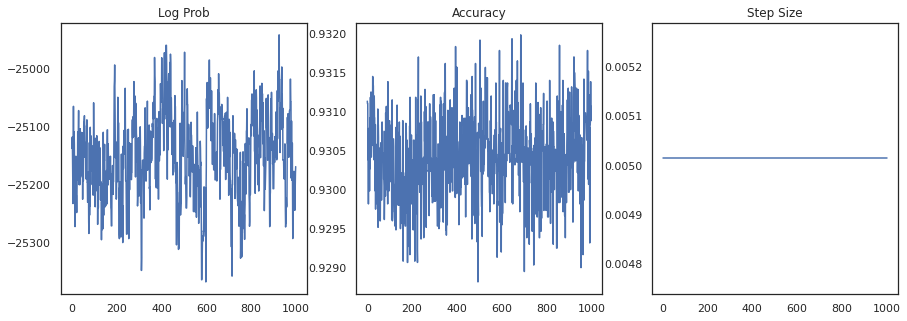

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(trace[0])
ax[0].set_title('Log Prob')
ax[1].plot(trace[1])
ax[1].set_title('Accuracy')
ax[2].plot(trace[2])
ax[2].set_title('Step Size')
plt.show()

If we ensemble the samples, we can compute a Bayesian model average to improve our performance.

In [0]:
@functools.partial(jax.pmap, axis_name='data', in_axes=(0, None), out_axes=None)
def bayesian_model_average(data, states):
  images, labels = data
  logits = jax.vmap(lambda w, b: images.dot(w) + b)(*states)
  probs = jax.nn.softmax(logits, axis=-1)
  bma_accuracy = (probs.mean(axis=0).argmax(axis=-1) == labels).mean()
  avg_accuracy = (probs.argmax(axis=-1) == labels).mean()
  return lax.pmean(bma_accuracy, axis_name='data'), lax.pmean(avg_accuracy, axis_name='data')

sharded_test_images, sharded_test_labels = shard((test_images, test_labels))
bma_acc, avg_acc = bayesian_model_average((sharded_test_images, sharded_test_labels), states)
print(f'Average Accuracy: {avg_acc}')
print(f'BMA Accuracy: {bma_acc}')
print(f'Accuracy Improvement: {bma_acc - avg_acc}')

Average Accuracy: 0.9188529253005981
BMA Accuracy: 0.9264000058174133
Accuracy Improvement: 0.0075470805168151855


A Bayesian model average increases our accuracy by almost 1%!

##### Example: MovieLens recommendation system

Let's now try doing inference with the MovieLens recommendations dataset, which is a collection of users and their ratings of various movies. Specifically, we can represent MovieLens as an $N \times M$ watch matrix $W$ where $N$ is the number of users and $M$ is the number of movies; we expect $N > M$. The entries of $W_{ij}$ are a boolean indicating whether or not user $i$ watched movie $j$. Note that MovieLens provides user ratings, but we're ignoring them to simplify the problem.


First, we'll load the dataset. We'll use the version with 1 million ratings.

In [0]:
movielens = tfds.as_numpy(tfds.load('movielens/1m-ratings', batch_size=-1))
GENRES = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
          'Thriller', 'Unknown', 'War', 'Western', '(no genres listed)'] 

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0.incompleteYKA3TG/movielens-train.tfrecord


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


We'll do some preprocessing of the dataset to obtain the watch matrix $W$.

In [0]:
raw_movie_ids = movielens['train']['movie_id']
raw_user_ids = movielens['train']['user_id']
genres = movielens['train']['movie_genres']

movie_ids, movie_labels = pd.factorize(movielens['train']['movie_id'])
user_ids, user_labels = pd.factorize(movielens['train']['user_id'])

num_movies = movie_ids.max() + 1
num_users = user_ids.max() + 1

movie_titles = dict(zip(movielens['train']['movie_id'],
                        movielens['train']['movie_title']))
movie_genres = dict(zip(movielens['train']['movie_id'],
                        genres))
movie_id_to_title = [movie_titles[movie_labels[id]].decode('utf-8')
                     for id in range(num_movies)]
movie_id_to_genre = [GENRES[movie_genres[movie_labels[id]][0]] for id in range(num_movies)]

watch_matrix = np.zeros((num_users, num_movies), bool)
watch_matrix[user_ids, movie_ids] = True
print(watch_matrix.shape)

(6040, 3706)


We can define a generative model for $W$, using a simple probabilistic matrix factorization model. We assume a latent $N \times D$ user matrix $U$ and a latent $M \times D$ movie matrix $V$, which when multiplied produce the logits of a Bernoulli for the watch matrix $W$. We'll also include a bias vectors for users and movies, $u$ and $v$.
$$
\begin{align*}
  U &\sim \mathcal{N}(0, 1) \quad 
  u \sim \mathcal{N}(0, 1)\\
  V &\sim \mathcal{N}(0, 1) \quad
  v \sim \mathcal{N}(0, 1)\\
  W_{ij} &\sim \textrm{Bernoulli}\left(\sigma\left(\left(UV^T\right)_{ij} + u_i + v_j\right)\right)
\end{align*}
$$

This is a pretty big matrix; 6040 user and 3706 movies leads to a matrix with over 22 million entries in it.
How do we approach sharding this model? Well, if we assume that $N > M$ (i.e. there are more users than movies), then it would make sense to shard the watch matrix across the user axis, so each device would have a chunk of watch matrix corresponding to a subset of users. Unlike the previous example, however, we'll also have to shard up the $U$ matrix, since it has an embedding for each user, so each device will be responsible for a shard of $U$ and a shard of $W$. On the other hand, $V$ will be unsharded and be synchronized across devices.

In [0]:
sharded_watch_matrix = shard(watch_matrix)

Before we write our `run`, let's quickly discuss the additional challenges with sharding the local random variable $U$. When running HMC, the vanilla `tfp.mcmc.HamiltonianMonteCarlo` kernel will sample momenta for each element of the chain's state. Previously, only unsharded random variables were part of that state, and the momenta were the same on each device. When we now have a sharded $U$, we need to sample different momenta on each device for $U$, while sampling the same momenta for $V$. To accomplish this, we can use `tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo` with a `Sharded` momentum distribution. As we continue to make parallel computation first-class, we may simplify this, e.g. by taking a shardedness indicator to the HMC kernel.

In [0]:
def make_run(*,
             axis_name,
             dim=20,
             num_chains=2,
             prior_variance=1.,
             step_size=1e-2,
             num_leapfrog_steps=100,
             num_burnin_steps=1000,
             num_results=500,
             ):
  @functools.partial(jax.pmap, in_axes=(None, 0), axis_name=axis_name)
  @jax.default_matmul_precision('tensorfloat32')
  def run(key, watch_matrix):
    num_users, num_movies = watch_matrix.shape

    Sharded = functools.partial(tfed.Sharded, shard_axis_name=axis_name)

    def prior_fn():
      user_embeddings = yield Root(Sharded(tfd.Sample(tfd.Normal(0., 1.), [num_users, dim]), name='user_embeddings'))
      user_bias = yield Root(Sharded(tfd.Sample(tfd.Normal(0., 1.), [num_users]), name='user_bias'))
      movie_embeddings = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_movies, dim], name='movie_embeddings'))
      movie_bias = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_movies], name='movie_bias'))
      return (user_embeddings, user_bias, movie_embeddings, movie_bias)
    prior = tfed.JointDistributionCoroutine(prior_fn)

    def model_fn():
      user_embeddings, user_bias, movie_embeddings, movie_bias = yield from prior_fn()
      logits = (jnp.einsum('...nd,...md->...nm', user_embeddings, movie_embeddings)
                + user_bias[..., :, None] + movie_bias[..., None, :])
      yield Sharded(tfd.Independent(tfd.Bernoulli(logits=logits), 2), name='watch')
    model = tfed.JointDistributionCoroutine(model_fn)

    init_key, sample_key = random.split(key)
    initial_state = prior.sample(seed=init_key, sample_shape=num_chains)

    def target_log_prob(*state):
      return model.log_prob((*state, watch_matrix))

    momentum_distribution = tfed.JointDistributionSequential([
      Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_users, dim]), 1.), 2)),
      Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_users]), 1.), 1)),
      tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_movies, dim]), 1.), 2),
      tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_movies]), 1.), 1),
    ])
    
    # We pass in momentum_distribution here to ensure that the momenta for 
    # user_embeddings and user_bias are also sharded
    kernel = tfem.PreconditionedHamiltonianMonteCarlo(target_log_prob, step_size,
                                                      num_leapfrog_steps,
                                                      momentum_distribution=momentum_distribution)

    num_adaptation_steps = int(0.8 * num_burnin_steps)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel, num_adaptation_steps)

    def trace_fn(state, pkr):
      return {
        'log_prob': target_log_prob(*state),
        'log_accept_ratio': pkr.inner_results.log_accept_ratio,
      }
    return tfm.sample_chain(
        num_results, initial_state,
        kernel=kernel,
        num_burnin_steps=num_burnin_steps,
        trace_fn=trace_fn,
        seed=sample_key)
  return run

We'll again run it once to cache the compiled `run`.

In [0]:
%%time
run = make_run(axis_name='data')
output = run(random.PRNGKey(0), sharded_watch_matrix)
jax.tree_map(lambda x: x.block_until_ready(), output)

CPU times: user 56 s, sys: 1min 24s, total: 2min 20s
Wall time: 3min 35s


Now we'll run it again without the compilation overhead.

In [0]:
%%time
states, trace = run(random.PRNGKey(0), sharded_watch_matrix)
jax.tree_map(lambda x: x.block_until_ready(), trace)

CPU times: user 28.8 s, sys: 1min 16s, total: 1min 44s
Wall time: 3min 1s


Looks like we completed about 150,000 leapfrog steps in about 3 minutes, so about 83 leapfrog steps per second! Let's plot the accept ratio and log density of our samples.

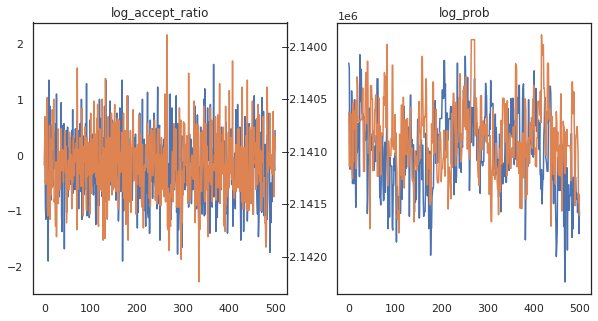

In [0]:
fig, axs = plt.subplots(1, len(trace), figsize=(5 * len(trace), 5))
for ax, (key, val) in zip(axs, trace.items()):
  ax.plot(val[0]) # Indexing into a sharded array, each element is the same
  ax.set_title(key);

Now that we have some samples from our Markov chain, let's use them to make some predictions. First, let's extract each of the components. Remember that the `user_embeddings` and `user_bias` are split across device, so we need to concatenate our `ShardedArray` to obtain them all. On the other hand, `movie_embeddings` and `movie_bias` are the same on every device, so we can just pick the value from the first shard.  We'll use regular `numpy` to copy the values from the TPUs back to CPU.

In [0]:
user_embeddings = np.concatenate(np.array(states.user_embeddings, np.float32), axis=2)
user_bias = np.concatenate(np.array(states.user_bias, np.float32), axis=2)
movie_embeddings = np.array(states.movie_embeddings[0], dtype=np.float32)
movie_bias = np.array(states.movie_bias[0], dtype=np.float32)
samples = (user_embeddings, user_bias, movie_embeddings, movie_bias)
print(f'User embeddings: {user_embeddings.shape}')
print(f'User bias: {user_bias.shape}')
print(f'Movie embeddings: {movie_embeddings.shape}')
print(f'Movie bias: {movie_bias.shape}')

User embeddings: (500, 2, 6040, 20)
User bias: (500, 2, 6040)
Movie embeddings: (500, 2, 3706, 20)
Movie bias: (500, 2, 3706)


Let's try to build a simple recommender system that utilizes the uncertainty captured in these samples. Let's first write a function that ranks movies according to the watch probability.

In [0]:
@jax.jit
def recommend(sample, user_id):
  user_embeddings, user_bias, movie_embeddings, movie_bias = sample
  movie_logits = (
      jnp.einsum('d,md->m', user_embeddings[user_id], movie_embeddings)
      + user_bias[user_id] + movie_bias)
  return movie_logits.argsort()[::-1]

We can now write a function that loops over all the samples and for each one, picks the top ranked movie that the user hasn't watched already. We can then see the counts of all recommended movies across the samples.

In [0]:
def get_recommendations(user_id): 
  movie_ids = []
  already_watched = set(jnp.arange(num_movies)[watch_matrix[user_id] == 1])
  for i in range(500):
    for j in range(2):
      sample = jax.tree_map(lambda x: x[i, j], samples)
      ranking = recommend(sample, user_id)
      for movie_id in ranking:
        if int(movie_id) not in already_watched:
          movie_ids.append(movie_id)
          break
  return movie_ids

def plot_recommendations(movie_ids, ax=None):
  titles = collections.Counter([movie_id_to_title[i] for i in movie_ids])
  ax = ax or plt.gca()
  names, counts = zip(*sorted(titles.items(), key=lambda x: -x[1]))
  ax.bar(names, counts)
  ax.set_xticklabels(names, rotation=90)

Let's take the user who has seen the most movies versus the one who has seen the least.

In [0]:
user_watch_counts = watch_matrix.sum(axis=1)
user_most = user_watch_counts.argmax()
user_least = user_watch_counts.argmin()
print(user_watch_counts[user_most], user_watch_counts[user_least])

2314 20


We hope our system has more certainty about `user_most` than `user_least`, given that we have more information about what sorts of movies `user_most` is  more likely to watch.

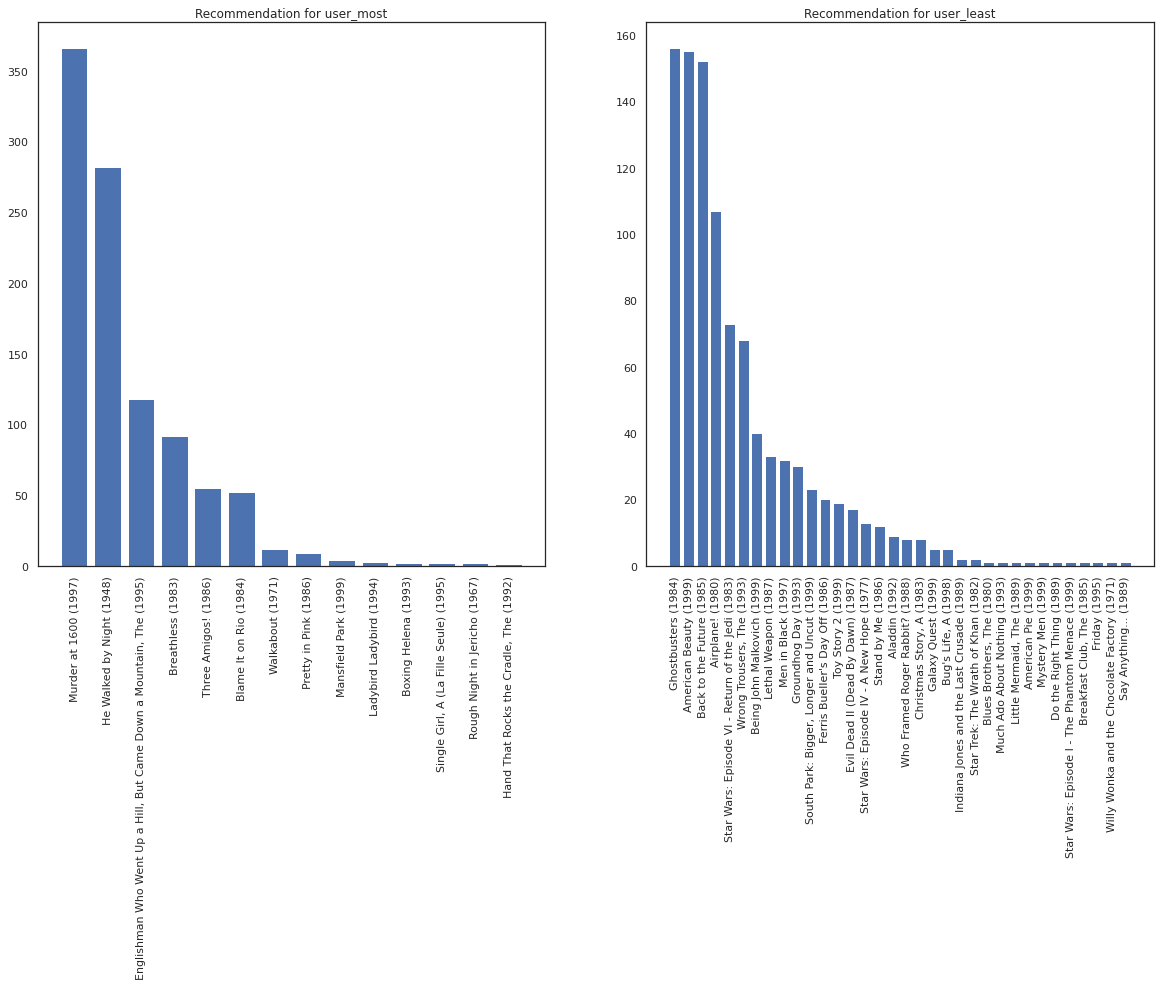

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
most_recommendations = get_recommendations(user_most)
plot_recommendations(most_recommendations, ax=ax[0])
ax[0].set_title('Recommendation for user_most')
least_recommendations = get_recommendations(user_least)
plot_recommendations(least_recommendations, ax=ax[1])
ax[1].set_title('Recommendation for user_least');

We see that there is more variance in our recommendations for `user_least` reflecting our additional uncertainty in their watch preferences.

We can also see look at the genres of the recommended movies.

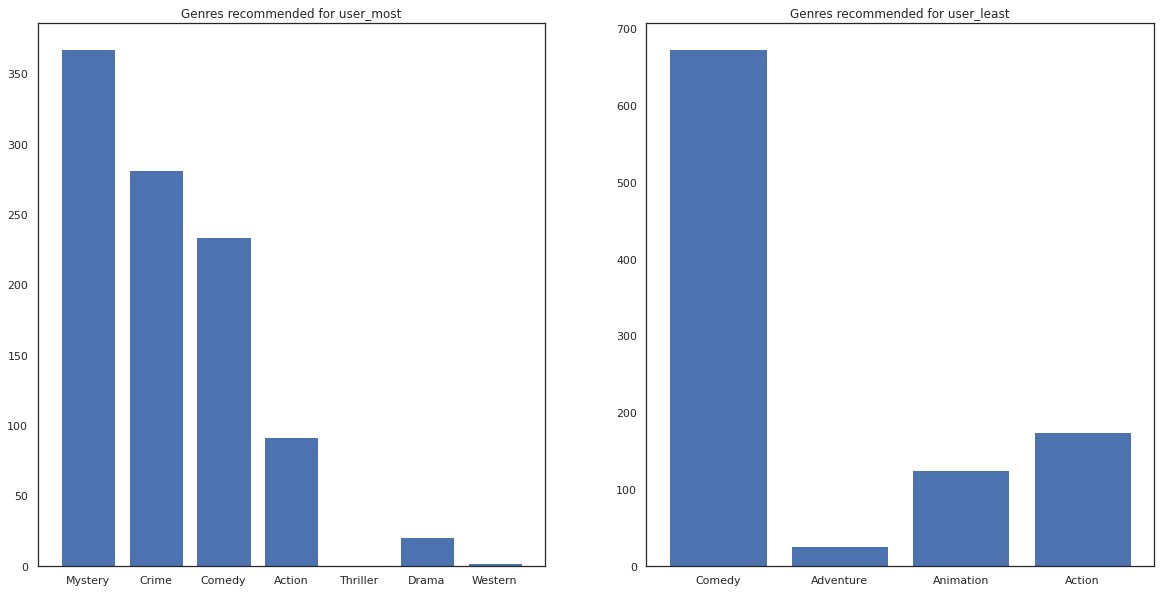

In [0]:
most_genres = collections.Counter([movie_id_to_genre[i] for i in most_recommendations])
least_genres = collections.Counter([movie_id_to_genre[i] for i in least_recommendations])
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].bar(most_genres.keys(), most_genres.values())
ax[0].set_title('Genres recommended for user_most')
ax[1].bar(least_genres.keys(), least_genres.values())
ax[1].set_title('Genres recommended for user_least');

`user_most` has seen a lot of movies and has been recommended more niche genres like mystery and crime whereas `user_least` has not watched many movies and was recommended more mainstream movies, which skew comedy and action.